# Welcome to PYNQ Audio
This notebook shows the basic recording and playback features of the PYNQ-Z2.  
It uses the audio jack `HP+MIC` to play back recordings; it can take inputs from 
the microphone on `HP+MIC` or `LINE_IN`. Pre-recorded audio sample can also be taken
as input. Moreover, visualization with matplotlib is shown.
## Create new audio object

In [1]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In [2]:
pAudio = base.audio
pAudio.set_volume(20)

## Bypass audio
Users can select either `LINE_IN`, or `HP+MIC` as the input port.
In the following example, we choose `LINE_IN`. To choose `MIC`:
```python
pAudio.select_microphone()
```
or choose `LINE_IN`:
```python
pAudio.select_line_in()
```

In [3]:
pAudio.select_line_in()

In [4]:
pAudio.bypass(seconds=5)

## Record and play
Record a 5-second sample and save it into a file.

In [5]:
pAudio.record(5)
pAudio.save("recording_1.wav")

## Load and play
Load a sample and play the loaded sample.

In [6]:
pAudio.load("/home/xilinx/jupyter_notebooks/base/audio/recording_0.wav")
pAudio.play()

## Play in notebook
Since the samples are in 24-bit PCM format, 
users can play the audio directly in notebook.

In [7]:
from IPython.display import Audio as IPAudio
IPAudio("/home/xilinx/jupyter_notebooks/base/audio/recording_0.wav")

## Plotting PCM data

Users can display the audio data in notebook:

1. Plot the audio signal's amplitude over time.
2. Plot the spectrogram of the audio signal.

The next cell reads the saved audio file and processes it into a `numpy` array.
Note that if the audio sample width is not standard, additional processing
is required. In the following example, the `sample_width` is read from the
wave file itself (24-bit dual-channel PCM audio, where `sample_width` is 3 bytes).

In [8]:
%matplotlib inline
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft

wav_path = "/home/xilinx/jupyter_notebooks/base/audio/recording_0.wav"
with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

### 1. Amplitude over time

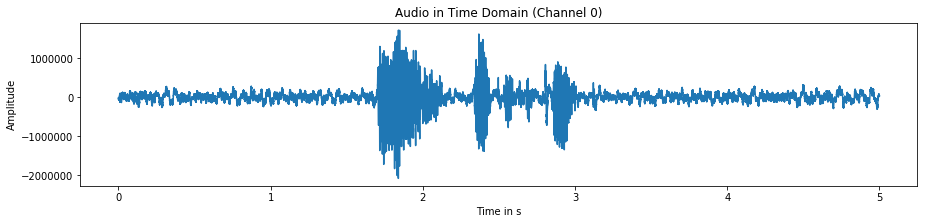

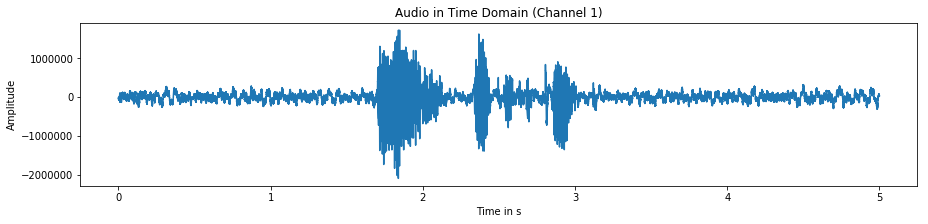

In [9]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:, channel_index])
    plt.show()

### 2. Frequency spectrum

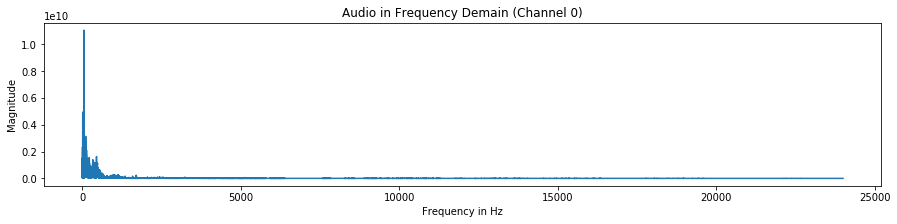

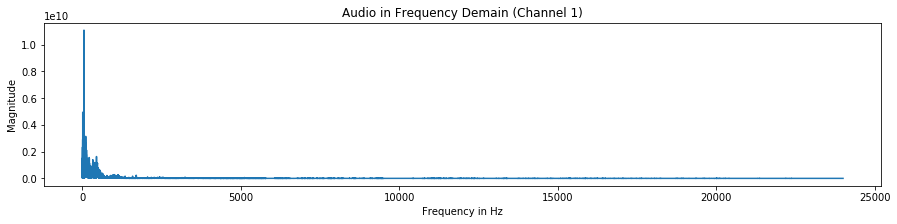

In [10]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Magnitude')
    temp = fft(frames[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.plot(xf, abs(yf))
    plt.show()

### 3. Frequency spectrum over time
Use the `classic` plot style for better display.

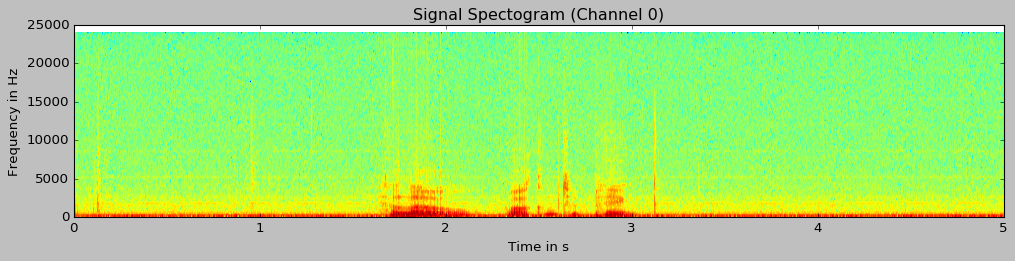

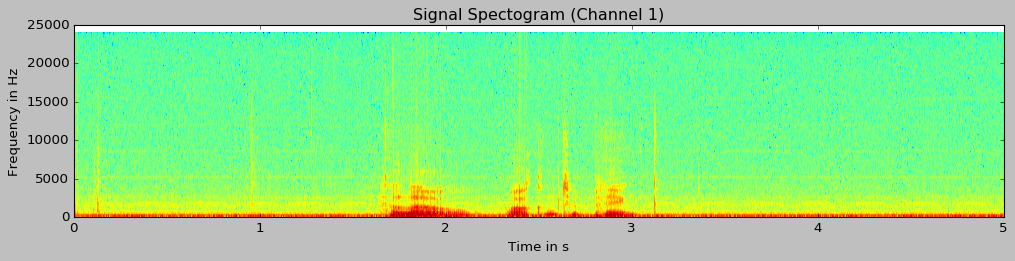

In [11]:
for channel_index in range(num_channels):
    np.seterr(divide='ignore', invalid='ignore')
    matplotlib.style.use("classic")
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Signal Spectogram (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Frequency in Hz')
    plt.specgram(frames[:, channel_index], Fs=sample_rate)